In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import gpytorch
# from voltron.robinhood_utils import GetStockData
import os
# import robin_stocks.robinhood as r
import pickle5 as pickle

sns.set_style("whitegrid")
sns.set_palette("bright")

sns.set(font_scale=2.0)
sns.set_style('whitegrid')

import sys
sys.path.append("../")
from voltron.likelihoods import VolatilityGaussianLikelihood
from voltron.kernels import BMKernel, VolatilityKernel
from voltron.models import BMGP, VoltronGP
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
Warning no robinhood utils.


In [2]:
# with open("../../stock_data.pkl", "rb") as handle:
#     raw_data = pickle.load(handle)
    
with open("../px-forecasting//stock_data.pkl", "rb") as handle:
    raw_data = pickle.load(handle)

In [3]:
np.unique(raw_data["symbol"])

array(['AAPL', 'F', 'JPM', 'SBUX', 'TSLA', 'VIRT'], dtype=object)

# Header

In [4]:
ntest = 200
ntrain = 200
tckrs = ['TSLA', "F", "JPM", "SBUX", 'AAPL', "VIRT"]
span = "5year"
interval = 'day'
T = 5.

## Data Setup

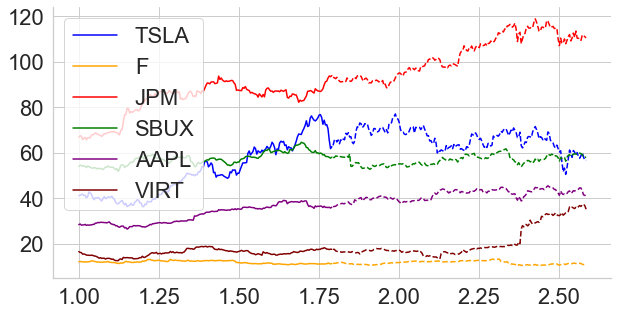

In [5]:
plt.figure(figsize = (10, 5))
idx = -2


colors = ["blue", "orange", "red", "green", "purple", "maroon"]

train_y_list = []
test_y_list = []
for i, tckr in enumerate(tckrs):
    data = raw_data[raw_data["symbol"] == tckr]
    ts = torch.linspace(0, T, data.shape[0]) + 1
    train_x = ts[:ntrain]
    test_x = ts[ntrain:(ntrain+ntest)]

    y = torch.FloatTensor(data['close_price'].to_numpy())
    train_y = y[:ntrain]
    test_y = y[ntrain:(ntrain+ntest)]

    dt = ts[1] - ts[0]
    train_y_list.append(train_y)
    test_y_list.append(test_y)

    plt.plot(train_x, train_y, label = tckr, color = colors[i])
    plt.plot(test_x, test_y, linestyle="--", color = colors[i])

    plt.legend()
sns.despine()
plt.show()

train_y = torch.stack(train_y_list)
test_y = torch.stack(test_y_list)


In [6]:
dt * 252

tensor(1.0016)

In [7]:
train_y.shape

torch.Size([6, 200])

In [8]:
log_returns = torch.log(train_y[..., 1:]/train_y[..., :-1])

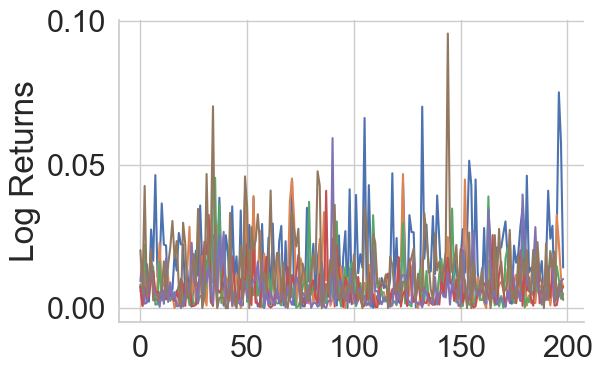

In [9]:
fig, ax = plt.subplots(dpi=100)
ax.plot(log_returns.abs().t(), label='Log Returns')

ax.set_ylabel("Log Returns")

# fig.legend()
sns.despine()

In [10]:
running_std = torch.stack([log_returns.t()[:i].std(0) for i in range(500)])
running_std[:5] = running_std[5]
f = running_std.clamp(min=1e-4).log()

In [11]:
running_std.shape

torch.Size([500, 6])

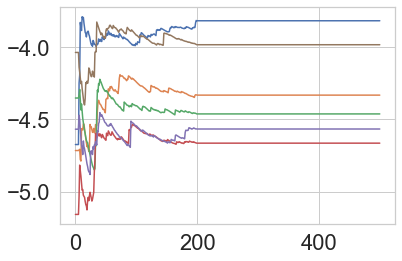

In [12]:
plt.plot(f)

## Now apply GCPV

In [13]:
from voltron.models import MultitaskVariationalGP

In [14]:
train_y.shape

torch.Size([6, 200])

In [15]:
train_x[:-1].shape

torch.Size([199])

In [16]:
%pdb

Automatic pdb calling has been turned ON


Using gp-exp parameterization.


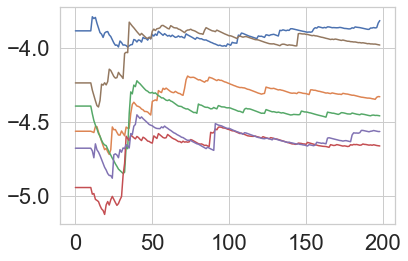

In [17]:
likelihood = VolatilityGaussianLikelihood(batch_shape=[train_y.shape[0]], param="exp")

# corresponds to ICM
covar_module = BMKernel
model = MultitaskVariationalGP(
    inducing_points=train_x[:-1], # likelihood=likelihood,
    covar_module=covar_module(), learn_inducing_locations=False,
    num_tasks = train_y.shape[0]
)
model.initialize_variational_parameters(likelihood=likelihood, x=train_x[:-1], y=log_returns.t())
# [print(x.constant.data.add_(-4.)) for x in model.mean_module.base_means]
# model.covar_module.base_kernel.raw_lengthscale.data = torch.tensor([[-5.]])

In [18]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {"params": model.parameters()}, 
    # {"params": likelihood.parameters(), "lr": 0.1}
], lr=0.01)

# "Loss" for GPs - the marginal log likelihood
# num_data refers to the number of training datapoints
mll = gpytorch.mlls.VariationalELBO(likelihood, model, train_y.numel())

In [19]:
batched_train_x = train_x[:-1]

In [20]:
%pdb

Automatic pdb calling has been turned OFF


In [21]:
print_every = 50
for i in range(training_iterations):
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    with gpytorch.settings.num_gauss_hermite_locs(75), gpytorch.settings.max_cholesky_size(3000):
        output = model(batched_train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, log_returns.t())
        loss.backward()
        if i % print_every == 0:
            print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
        optimizer.step()

Iter 1/50 - Loss: -13.674


/Users/wesleymaddox/Documents/GitHub/wjm_gpytorch/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


In [22]:
model.eval();
likelihood.eval();
predictive = model(train_x)
pred_scale = likelihood(predictive).scale.mean(0).detach()
samples = likelihood(predictive).scale.detach()

/Users/wesleymaddox/Documents/GitHub/wjm_gpytorch/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


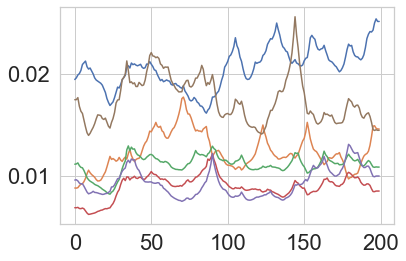

In [23]:
plt.plot(predictive.mean.detach().exp())

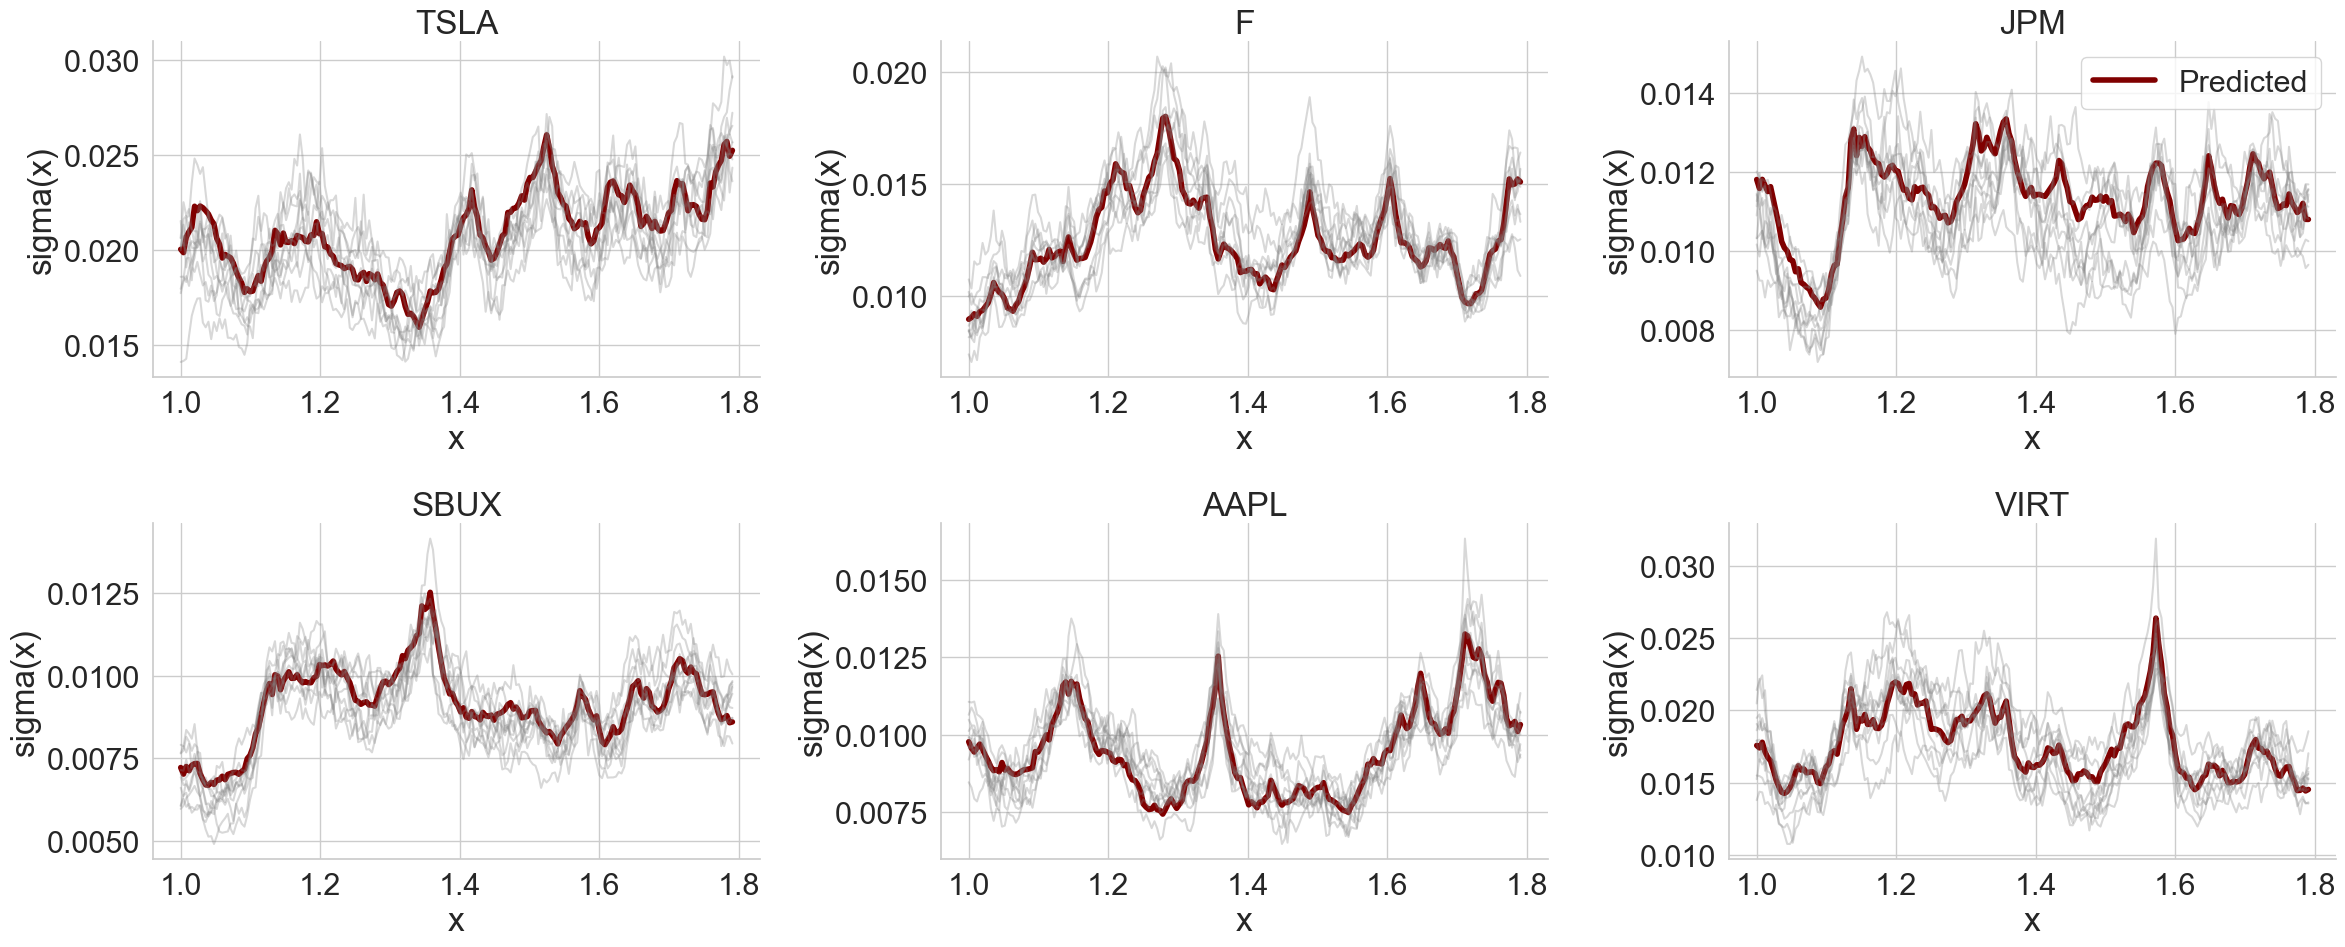

In [24]:
fig, ax = plt.subplots(2, 3, figsize = (24, 10), dpi=100)

ax = ax.reshape(-1)
for i in range(6):
    ax[i].plot(train_x, pred_scale[:,i], label = "Predicted", color = "maroon", linewidth=4)
    ax[i].plot(train_x, samples[..., i].t(), c='gray', alpha=0.3)
    # plt.plot(ts, V[1:], label = "Actual", color = "orangered")
    ax[i].set_xlabel("x")
    ax[i].set_ylabel("sigma(x)")
    ax[i].set_title(tckrs[i])
ax[2].legend()

# fig, ax = plt.subplots(dpi=100)
# ax.plot(train_x, pred_scale, label = "Predicted")
# ax2 = ax.twinx()
# ax2.plot(train_x, V[1:], label = "Actual", color='orangered')

# ax.set_ylabel("Predicted Vol")
# ax2.set_ylabel("Actual Vol")


plt.tight_layout()
sns.despine()

In [25]:
log_returns.shape

torch.Size([6, 199])

In [26]:
pred_scale.shape

torch.Size([200, 6])

Text(0.5, 1.0, 'Log returns')

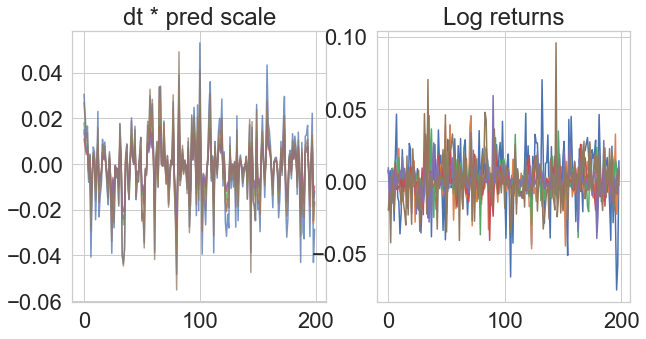

In [27]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].plot((torch.randn(pred_scale.shape[0])*pred_scale.t()).t(), alpha=0.75)
ax[1].plot(log_returns.t())

ax[0].set_title("dt * pred scale")
ax[1].set_title("Log returns")

## Now Do Forward Predictions with Voltron

In [28]:
pred_scale = pred_scale / dt**0.5

In [29]:
from voltron.models import MultitaskBMGP

In [30]:
train_x.shape

torch.Size([200])

In [31]:
pred_scale.shape

torch.Size([200, 6])

In [32]:
vol_lh = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=6)
vol_lh.noise.data = torch.tensor([1e-6])
vol_model = MultitaskBMGP(train_x, pred_scale.log(), vol_lh)

optimizer = torch.optim.Adam([
    {'params': vol_model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.01)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(vol_lh, vol_model)

for i in range(500):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = vol_model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, pred_scale.log())
    loss.backward()
    if i % 50 == 0:
        print(loss.item(), vol_model.covar_module.data_covar_module.raw_vol.item())
    optimizer.step()
    
print((vol_model.covar_module.data_covar_module.raw_vol))
# print(vol_model.mean_module.constant.data.exp())

1.1393488645553589 -1.3862943649291992
0.9298147559165955 -1.082345724105835
0.7116599678993225 -1.3037054538726807
0.4755156934261322 -1.7235273122787476
0.23077265918254852 -2.139613151550293
-0.01420491561293602 -2.479604721069336
-0.2514367699623108 -2.718032121658325
-0.47294220328330994 -2.7929325103759766
-0.6738402247428894 -2.679673194885254
-0.8522056937217712 -2.4209158420562744
Parameter containing:
tensor([-1.9026], requires_grad=True)


In [33]:
print(train_x.shape, train_y.shape, pred_scale.shape)

torch.Size([200]) torch.Size([6, 200]) torch.Size([200, 6])


In [34]:
voltron_lh = gpytorch.likelihoods.GaussianLikelihood()
voltron = VoltronGP(train_x, train_y.log(), voltron_lh, pred_scale.t())
# voltron.mean_module = gpytorch.means.LinearMean(1, batch_shape=torch.Size((6,)))
voltron.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size((6,)))
voltron.likelihood.raw_noise.data = torch.tensor([1e-6])
voltron.vol_lh = vol_lh
voltron.vol_model = vol_model

grad_flags = [False, True, True, True, *[False] * len(list(vol_model.named_parameters()))]

for idx, (n, p) in enumerate(voltron.named_parameters()):
    # print(n)
    p.requires_grad = grad_flags[idx]
    
voltron.train();
voltron_lh.train();
voltron.vol_lh.train();
voltron.vol_model.train();

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': voltron.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)



In [35]:
train_y.shape

torch.Size([6, 200])

In [36]:
# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(voltron_lh, voltron)

for i in range(500):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = voltron(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y.log()).sum()
    loss.backward()
    if i % 50 == 0:
        print(loss.item())
    optimizer.step()

23.749719619750977
4.577343463897705
4.4848761558532715
4.484158039093018
4.484154224395752
4.484154224395752
4.484154224395752
4.484154224395752
4.484154224395752
4.484154224395752


## Predict

In [37]:
%pdb

Automatic pdb calling has been turned ON


In [38]:
nvol = 10
npx = 10
num_tasks = 6
vol_paths = torch.zeros(num_tasks, nvol, ntest)
px_paths = torch.zeros(num_tasks,  npx*nvol, ntest)

voltron.vol_model.eval();
voltron.eval();

for vidx in range(nvol):
    print(vidx)
    vol_pred = voltron.vol_model(test_x).sample().exp()
    vol_paths[:, vidx, :] = vol_pred.detach().t()
    
    px_pred = voltron.GeneratePrediction(test_x, vol_pred.t(), npx)
    px_pred = px_pred.exp()
    px_paths[:, vidx*npx:(vidx*npx+npx), :] = px_pred.detach().transpose(-1, -2)

0
1
2
3
4
5
6
7
8
9


In [39]:
pred_scale.shape

torch.Size([200, 6])

In [40]:
# pred_mean = voltron.mean_module(test_x).detach().exp()

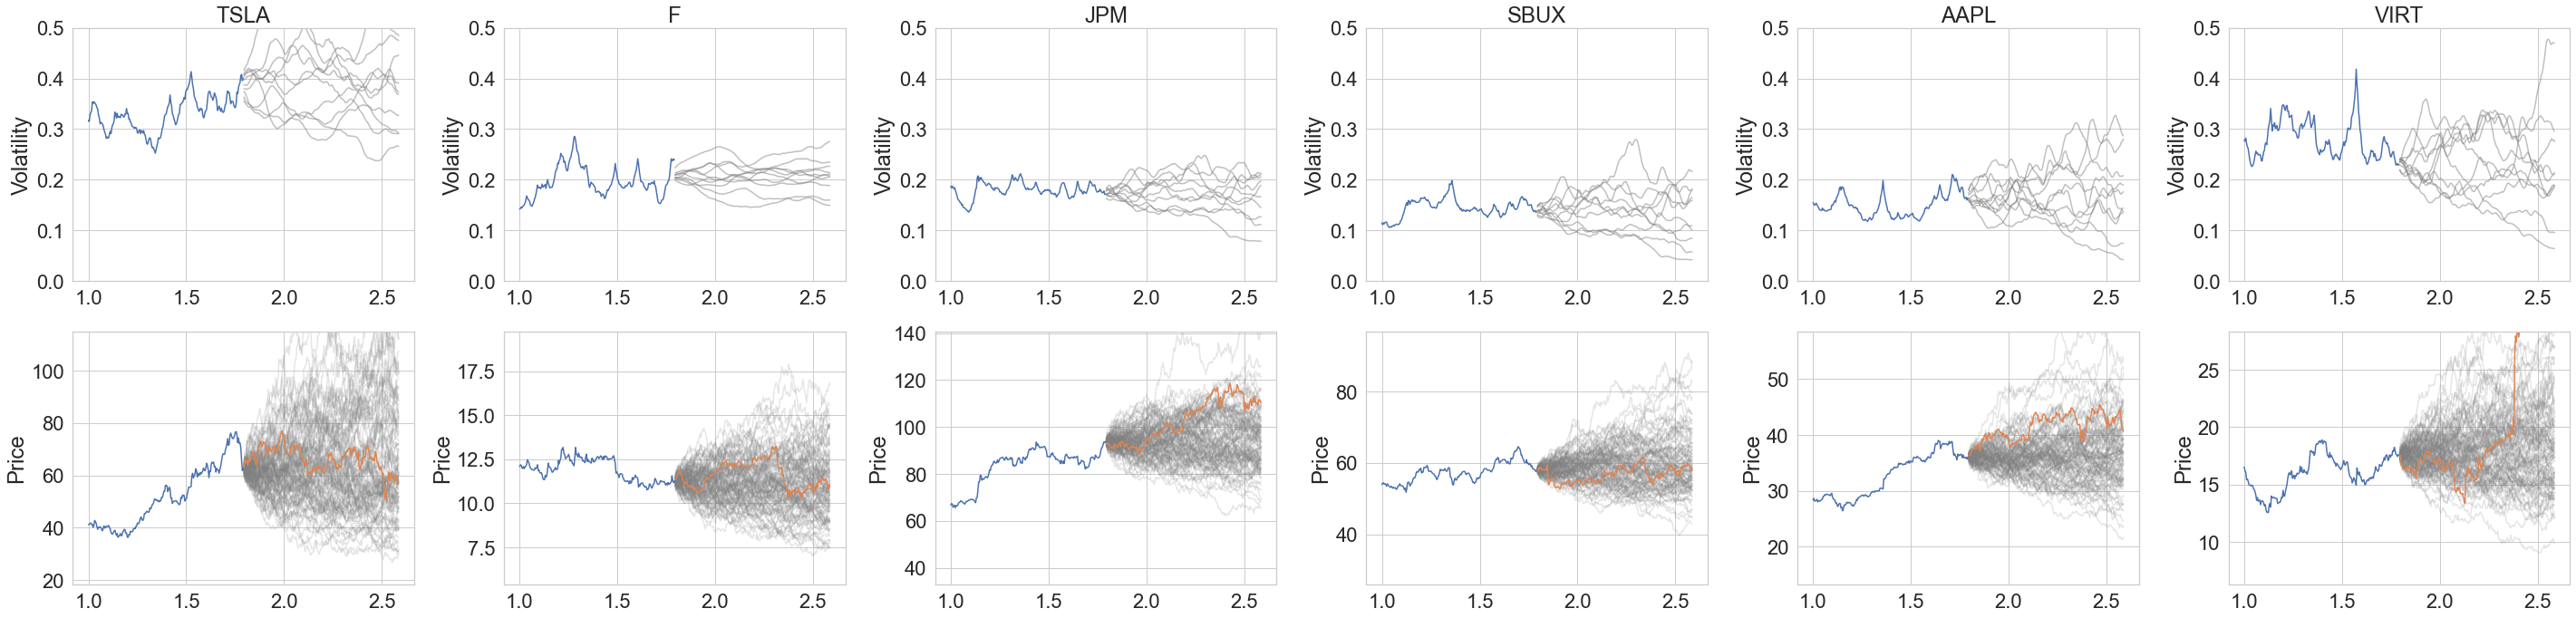

In [41]:
fig, ax = plt.subplots(2, 6, figsize = (40, 10))

for i in range(6):
    
    ax[0, i].plot(train_x, pred_scale[..., i])
    ax[0, i].plot(test_x, vol_paths[i].t(), color = "gray", alpha = 0.5)

    ax[1, i].plot(test_x, px_paths[i].t(), color = "gray", alpha = 0.2)
    # ax[1, i].plot(test_x, pred_mean.exp()[i,:,0].t(), color = "black")
    ax[1, i].plot(train_x, train_y[i])
    ax[1, i].plot(test_x, test_y[i])
    # ax[1, i].plot(test_x, pred_mean[i], lw=3.)

    # ax[0,i].set_title("Volatility")
    # ax[1,i].set_title("Price")
    ax[0, i].set_ylabel("Volatility")
    ax[1, i].set_ylabel("Price")
    ax[0, i].set_title(tckrs[i])
    ax[0, i].set_ylim((0, 0.5))
    ax[1, i].set_ylim((0.5 * train_y[i].min(), 1.5 * train_y[i].max()))

# [ax[0, i].set_ylim((0, 0.2)) for i in range(6)]
# [ax[1, i].set_ylim((0, 150)) for i in range(6)]
plt.tight_layout()
plt.show();

In [42]:
est_inter_task_covar = voltron.vol_model.covar_module.task_covar_module.covar_matrix.evaluate()

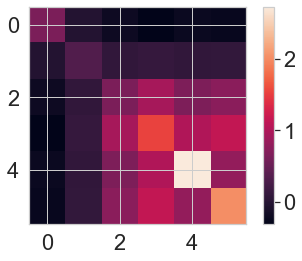

In [43]:
f = plt.imshow(est_inter_task_covar.detach())
plt.colorbar(f)

In [44]:
sqrt_inv_diag = torch.diag(est_inter_task_covar.diag().sqrt().reciprocal())
est_corr = sqrt_inv_diag.matmul(est_inter_task_covar).matmul(sqrt_inv_diag)

In [45]:
est_corr

tensor([[ 1.0000, -0.0574, -0.3186, -0.3163, -0.1663, -0.2180],
        [-0.0574,  1.0000,  0.1727,  0.1714,  0.0901,  0.1182],
        [-0.3186,  0.1727,  1.0000,  0.9521,  0.5005,  0.6564],
        [-0.3163,  0.1714,  0.9521,  1.0000,  0.4968,  0.6516],
        [-0.1663,  0.0901,  0.5005,  0.4968,  1.0000,  0.3426],
        [-0.2180,  0.1182,  0.6564,  0.6516,  0.3426,  1.0000]])

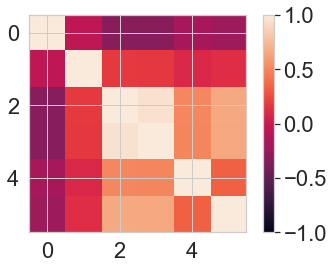

In [46]:
f = plt.imshow(est_corr.detach(), vmin=-1.0, vmax=1.0)
plt.colorbar(f)

# 